<a href="https://colab.research.google.com/github/GA239/DS_course/blob/master/HW7/tsk1/TF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tensorflow-gpu

In [2]:
# import tensorflow as tf
# import os
# tf.__version__
import matplotlib.pylab as plt
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
tf.__version__

'2.2.0'

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
# read dataset
DRIVE = '/content/drive/My Drive'
titanic_path = os.path.join(DRIVE, 'titanic_precessed.csv')

In [7]:
df = pd.read_csv(titanic_path, index_col=0)
df.columns

Index(['survived', 'sex', 'Family', 'Is_Alone', 'Cabin_A10', 'Cabin_A11',
       'Cabin_A14', 'Cabin_A16', 'Cabin_A18', 'Cabin_A19',
       ...
       'Title_Rev', 'Title_Sir', 'Title_the Countess', 'Fare_Low', 'Fare_Mid',
       'Fare_High_Mid', 'Fare_High', 'Class_1', 'Class_2', 'Class_3'],
      dtype='object', length=256)

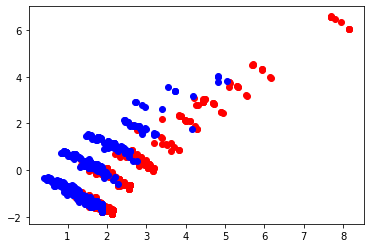

In [8]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def plot_titanic(data, target):
  svd = TruncatedSVD(n_components=2)
  Y_r = data[[target]]
  X_r = data.drop([target], axis=1)
  # pca = PCA(n_components=2)
  X_r = svd.fit(X_r).transform(X_r)
  a = pd.DataFrame(X_r, index = data.index)
  a_1 = a[a.index.isin(Y_r[Y_r[target] == 1].index)]
  a_0 = a[a.index.isin(Y_r[Y_r[target] == 0].index)]

  plt.scatter(a_0[0], a_0[1], color='red')
  plt.scatter(a_1[0], a_1[1], color='blue')

plot_titanic(df, 'survived')

In [9]:
df = pd.concat([df, pd.get_dummies(df.survived, prefix='survived')], axis=1)
df.drop(['survived'], axis=1, inplace=True)

In [10]:
df.head(5)

,sex,Family,Is_Alone,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,Cabin_A19,Cabin_A20,Cabin_A21,Cabin_A23,Cabin_A24,Cabin_A26,Cabin_A29,Cabin_A31,Cabin_A32,Cabin_A34,Cabin_A36,Cabin_A5,Cabin_A6,Cabin_A7,Cabin_A9,Cabin_B10,Cabin_B101,Cabin_B102,Cabin_B11,Cabin_B18,Cabin_B19,Cabin_B20,Cabin_B22,Cabin_B24,Cabin_B26,Cabin_B28,Cabin_B3,Cabin_B30,Cabin_B35,Cabin_B36,Cabin_B37,Cabin_B38,...,boat_D,boat_NA,"Age_Range_(0, 10]","Age_Range_(10, 20]","Age_Range_(20, 30]","Age_Range_(30, 40]","Age_Range_(40, 50]","Age_Range_(50, 60]","Age_Range_(60, 70]","Age_Range_(70, 80]",Emb_C,Emb_Q,Emb_S,Title_Capt,Title_Col,Title_Don,Title_Dona,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Fare_Low,Fare_Mid,Fare_High_Mid,Fare_High,Class_1,Class_2,Class_3,survived_0,survived_1
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [11]:
Y = df[['survived_0',	'survived_1']]
X = df.drop(['survived_0',	'survived_1'], axis=1)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
Xtrain, Xtest, Ytrain, Ytest, =  train_test_split(X, Y)
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((981, 255), (981, 2), (328, 255), (328, 2))

In [14]:
# Xtrain.head(5)

In [15]:
Xtest.shape

(328, 255)

In [16]:
# svd = TruncatedSVD(n_components=2)
# svd.fit(Xtrain)

# Xtrain = pd.DataFrame(svd.transform(Xtrain), index=Ytrain.index)
# Xtest = pd.DataFrame(svd.transform(Xtest), index=Ytest.index)

# Здесь вопрос: Я понимаю, что декомпозиция - уменьшает количество информации, 
# однако получается, что если бы у меня просто были такие исходные данные, то
# согласно графику они линейно разделимы. Почему в случае подачи декомпозиции на
# на вход и без того малое качество ухудшается? 

In [17]:
Xtrain.shape

(981, 255)

In [18]:
tf.reset_default_graph()

In [19]:
N_EPOCHS = 10000
display_step = 1000 

In [20]:
# Step 2: create placeholders for X and Y
X = tf.placeholder(tf.float32,  [None, Xtrain.shape[1]], name='X')
Y = tf.placeholder(tf.float32, [None, Ytrain.shape[1]], name='Y')

In [21]:
# Step 3: create weight and bias
w = tf.get_variable(name='weights', shape=(Xtrain.shape[1], Ytrain.shape[1]), 
                    initializer=tf.random_normal_initializer())
b = tf.get_variable(name='bias', shape=(1, Ytrain.shape[1]), 
                    initializer=tf.zeros_initializer())

In [22]:
# Step 4: build model to predict Y
logits = tf.matmul(X, w) + b

In [23]:
# Step 5: use cross_entropy as the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(Y, logits), name='loss')

In [24]:
# Step 6: using AdamOptimizer with learning rate of 0.001 to minimize loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [25]:
# Step 7: calculate accuracy with test set
preds = tf.nn.softmax(logits)
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [26]:
with tf.Session() as sess:
  # Step 7: initialize the necessary variables, in this case, w and b
  sess.run(tf.global_variables_initializer()) 

  print('\n--- до обучения ---\n')
  print("Точность TEST:  %s" % sess.run(accuracy, feed_dict={X: Xtest, Y: Ytest})) 
  print("Точность TRAIN: %s" % sess.run(accuracy, feed_dict={X: Xtrain, Y: Ytrain})) 

  print('\n--- обучение ---\n')
  # Step 8: train the model
  for i in range(N_EPOCHS): 
    Xbatch = Xtrain.sample(200)
    Ybatch = Ytrain[Ytrain.index.isin(Xbatch.index)]
    # Session execute optimizer and fetch values of loss
    _, l, a_val = sess.run([optimizer, loss, accuracy], feed_dict={X: Xbatch, Y:Ybatch}) 
    if (i+1) % display_step == 0: 
      print(f'Эпоха {i+1}:  loss = {l}  ----   acc = {a_val}')

  print('\n--- после обучения ---\n')
  print("Точность TEST:  %s" % sess.run(accuracy, feed_dict={X: Xtest, Y: Ytest})) 
  print("Точность TRAIN: %s" % sess.run(accuracy, feed_dict={X: Xtrain, Y: Ytrain})) 


--- до обучения ---

Точность TEST:  0.38109756
Точность TRAIN: 0.382263

--- обучение ---

Эпоха 1000:  loss = 0.7951542139053345  ----   acc = 0.5550000071525574
Эпоха 2000:  loss = 0.7036765217781067  ----   acc = 0.5649999976158142
Эпоха 3000:  loss = 0.6974981427192688  ----   acc = 0.5699999928474426
Эпоха 4000:  loss = 0.6728716492652893  ----   acc = 0.6000000238418579
Эпоха 5000:  loss = 0.6747948527336121  ----   acc = 0.6349999904632568
Эпоха 6000:  loss = 0.6637211441993713  ----   acc = 0.6200000047683716
Эпоха 7000:  loss = 0.6805303692817688  ----   acc = 0.6050000190734863
Эпоха 8000:  loss = 0.6710085868835449  ----   acc = 0.6050000190734863
Эпоха 9000:  loss = 0.6600451469421387  ----   acc = 0.625
Эпоха 10000:  loss = 0.6861094832420349  ----   acc = 0.574999988079071

--- после обучения ---

Точность TEST:  0.63109756
Точность TRAIN: 0.6106014
